In [1]:
import healpy as hp
import matplotlib
import matplotlib.pyplot as plt
import os
os.environ['DISABLE_MPI']="true"
import numpy as np
from falafel import utils, qe
import pytempura
import solenspipe
from pixell import lensing, curvedsky, enmap
from pixell import utils as putils
from os.path import join as opj
import argparse
import yaml
from collections import OrderedDict
from prepare_maps import safe_mkdir, get_disable_mpi, DEFAULTS, get_cmb_alm_unlensed, get_cmb_seeds
from orphics import maps
from websky_model import WebSky
from copy import deepcopy
import sys
from scipy.signal import savgol_filter

/global/u1/m/maccrann/cmb/ksz2/prepare_maps.py:48: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  DEFAULTS=yaml.load(f)


Set some options e.g. l ranges, beam, noise level for filters  

In [2]:
#lmax for SHTs
mlmax=6000
#lmin and lmax for filter
lmin=3000
lmax=4000
#beam and noise
noise_sigma = 10.
beam_fwhm = 1.
ells = np.arange(mlmax+1)
bfact = maps.gauss_beam(beam_fwhm,ells)**2.
Nl_tt = (noise_sigma*np.pi/180./60.)**2./bfact
nells = {"TT":Nl_tt, "EE":2*Nl_tt, "BB":2*Nl_tt}

Read in CIB map, convert to temperature, and then to alms

In [3]:
cib_map = hp.read_map("/global/cscratch1/sd/maccrann/cmb/websky/cib_nu0093.fits")
#convert to temperature
cib_map *= 4.6831e3
cib_alms = hp.map2alm(cib_map, lmax=mlmax)

/global/homes/m/maccrann/.conda/envs/lenspipe/lib/python3.7/site-packages/healpy/fitsfunc.py:369: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/global/homes/m/maccrann/.conda/envs/lenspipe/lib/python3.7/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 4096
  warnings.warn("NSIDE = {0:d}".format(nside))
/global/homes/m/maccrann/.conda/envs/lenspipe/lib/python3.7/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/global/homes/m/maccrann/.conda/envs/lenspipe/lib/python3.7/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))

Build filter. The filter is $(C_l^{ksz})^{0.5}/C_l^{\mathrm{total}}$. 
Start by getting the CMB part using `falafel.utils.get_theory_dict`

In [4]:
#CMB theory for filters                                                                                                                                                                                 
ucls,tcls = utils.get_theory_dicts(grad=True,
                                   nells=nells, lmax=mlmax)

Now read in the kSZ alms, measure $C_l$, smooth it, and add to the total $C_l$

In [5]:
#And ksz2 filter                                                                                                                                                                                        
#Read alms and get (smoothed) Cl for filter                                                                                                                                                                                                                                                                                                                                                      
alm_file = "tests/alms_4e3_2048_50_50_ksz.fits"
alms=hp.fitsfunc.read_alm(alm_file)
alm_lmax=hp.Alm.getlmax(len(alms))
if alm_lmax>mlmax:
    alms = utils.change_alm_lmax(
        alms, mlmax)
elif alm_lmax<mlmax:
    raise ValueError("alm_lmax (=%d) < mlmax (=%d)"%(
        alm_lmax, mlmax)
                     )
    
cl = curvedsky.alm2cl(alms)
d = ells*(ells+1)*cl
d_smooth = savgol_filter(d, 101, 3)
cl_smooth = d_smooth/ells/(ells+1)
cl_smooth[0]=0.
profile = cl_smooth**0.5

#Add kSZ cl to total Cl. Not sure if this 
#makes much difference.
tcls['TT'][:len(cl_smooth)] += cl_smooth

def apply_W_filter(alms):
    f = np.zeros(mlmax)
    f[lmin:lmax+1] = (profile / tcls['TT'])[lmin:lmax+1]
    return curvedsky.almxfl(alms, f)

/global/homes/m/maccrann/.conda/envs/lenspipe/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide


Now apply the filter and get the K map, and measure it's $C_l$. 

In [16]:
#Filter the cib alms
cib_alms_filtered = apply_W_filter(cib_alms)
hp.fitsfunc.write_alm("cib_alms_filtered.fits",cib_alms_filtered)

#K is squared, filtered map
cib_K_map = (hp.alm2map(cib_alms_filtered, 4096))**2

/global/homes/m/maccrann/.conda/envs/lenspipe/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/global/homes/m/maccrann/.conda/envs/lenspipe/lib/python3.7/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))


In [7]:
#Get C(l) of K map
cib_K_alm = (hp.map2alm(cib_K_map, lmax=1000))
cib_cl_KK = hp.alm2cl(cib_K_alm)

Ok so that's the raw auto for the CIB map. Now get the $N_0$. For this we just measure the power spectrum of the input CIB map, generate a Gaussian sim, and make the same measurement on that sim. 

In [8]:
#first get the C_l
cib_cl = curvedsky.alm2cl(cib_alms)

In [9]:
#Now generate the random alms
sim_alm = curvedsky.rand_alm(cib_cl, seed=1234)

Make sure this has the right power spectrum

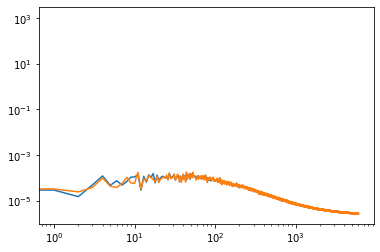

In [13]:
%matplotlib inline
fig,ax=plt.subplots()
#the one we measured from the cib alms
ax.plot(cib_cl)
#the one from the alms we just generated
ax.plot(curvedsky.alm2cl(sim_alm))
ax.set_yscale('log')
ax.set_xscale('log')

In [14]:
sim_alm_filtered = apply_W_filter(sim_alm)
#Convert to K map
sim_K_map = (hp.alm2map(sim_alm_filtered, 4096))**2
#Convert to alms and get C_l
sim_K_alm = hp.map2alm(sim_K_map, lmax=1000)
sim_cl_KK = hp.alm2cl(sim_K_alm)

/global/homes/m/maccrann/.conda/envs/lenspipe/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/global/homes/m/maccrann/.conda/envs/lenspipe/lib/python3.7/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))


Now plot both

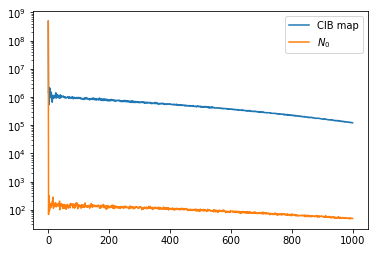

In [15]:
%matplotlib inline
fig,ax=plt.subplots()
ax.plot(cib_cl_KK, label="CIB map")
ax.plot(sim_cl_KK, label='$N_0$')
ax.legend()
ax.set_yscale('log')

WTF. $N_0$ is way smaller...

Plot the filtered map?

In [19]:
res=2. #arcmin
shape,wcs = enmap.fullsky_geometry(res=res * putils.arcmin)
cib_map_filtered = enmap.zeros(shape,wcs)
curvedsky.alm2map(cib_alms_filtered, cib_map_filtered)

ndmap([[ -7.73144918  -7.73144918  -7.73144918 ...  -7.73144918  -7.73144918
   -7.73144918]
 [110.88756142 110.85368258 110.81970585 ... 110.9886102  110.95502526
  110.92134232]
 [ 42.867258    42.84426795  42.82107646 ...  42.93502149  42.91263458
   42.89004681]
 ...
 [-54.45619141 -54.27753597 -54.09844427 ... -54.98953103 -54.81218984
  -54.63440967]
 [ 40.85887889  40.8992554   40.93967062 ...  40.73798338  40.77824271
   40.81854127]
 [-82.5263381  -82.5263381  -82.5263381  ... -82.5263381  -82.5263381
  -82.5263381 ]],car:{cdelt:[-0.03333,0.03333],crval:[0.01667,0],crpix:[5400,2701]})

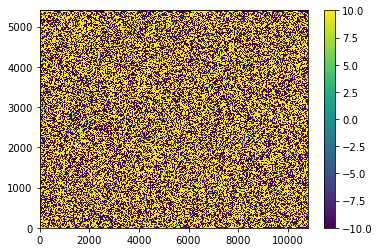

In [22]:
%matplotlib inline
fig,ax=plt.subplots()
im = ax.pcolormesh(cib_map_filtered, vmin=-10.,vmax=10.)
fig.colorbar(im, ax=ax)